In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
import cv2

Using TensorFlow backend.


In [3]:
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/valid'

# number of epochs to train top model
epochs = 20
# batch size used by flow_from_directory and predict_generator
batch_size = 16

In [4]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        generator, predict_size_train)

    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)

In [5]:
def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    
    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    print(" ")  
    
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

In [6]:
def predict(pimage_path):
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('class_indices.npy').item()

    num_classes = len(class_dictionary)

    # add the path to your test image below
    #image_path = 'data/test/1/barcode6100.jpg'
    image_path = pimage_path

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    print("Image ID: {}, Label: {}".format(inID, label))

    # display the predictions with the image
    cv2.putText(orig, "Predicted: {}".format(label), (10, 30), cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

    # Plot
    print("Classification")
    plt.imshow(orig)
    #cv2.imshow("Classification", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Found 248 images belonging to 2 classes.
248
{'0': 0, '1': 1}
2
Found 90 images belonging to 2 classes.
Found 248 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 6,423,298
Trainable params: 6,423,298
Non-trainable params: 0
_________________________________________________________________
Train on 248 samples, validate on 90 samples
Epoch 1/20
248/248 [==============

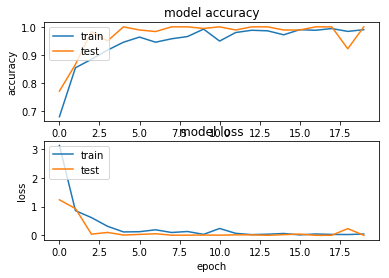

In [7]:
save_bottlebeck_features()
train_top_model()


[INFO] loading and preprocessing image...
1/1 [==============================] - 0s
Image ID: 1, Label: 1
Classification


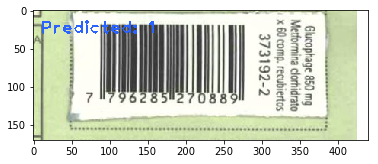

In [8]:
from IPython.display import clear_output, Image, display
# Troquel Testing OK 
predict('data/test/1/barcode6100.jpg')

cv2.destroyAllWindows()

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s
Image ID: 0, Label: 0
Classification


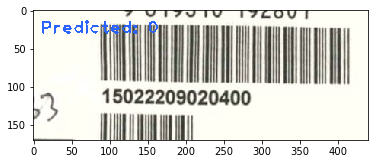

In [9]:
# Troquel Testing NOK 
predict('data/test/0/barcode75.jpg')

cv2.destroyAllWindows()